In [119]:
# Import PyTorch

import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

### Getting a Dataset

In [121]:
# Load data and labels from NumPy files
image_data = np.load('drive/MyDrive/Breast Cancer Images/X.npy')  # Shape: (num_samples, height, width, channels)
labels = np.load('drive/MyDrive/Breast Cancer Images/Y.npy')  # Shape: (num_samples,)

In [122]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Write a transform from image

data_transform = transforms.Compose([
    # Convert NumPy array to PIL Image
    transforms.ToPILImage(),
    # Resize our images to 64 x 64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [123]:
# Custom Dataset class

class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [124]:
# Create dataset instances
dataset = NumpyDataset(image_data, labels, transform=data_transform)

In [125]:
dataset.labels

array([0, 0, 0, ..., 1, 1, 1])

In [126]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split

# Define the size of your train and test sets
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

# Use random_split to split indices randomly
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [127]:
# Turn train and test dataset into dataloader

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e61488d2d40>,
 <torch.utils.data.dataloader.DataLoader at 0x7e61488d3c70>)

In [128]:
len(train_dataloader), len(test_dataloader)

(139, 35)

In [129]:
len(train_dataset), len(test_dataset)

(4437, 1110)

In [130]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


In [131]:
# Check out what's inside the training dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Image Size: torch.Size([64, 64, 3])
Label: 0, Label Size: torch.Size([])


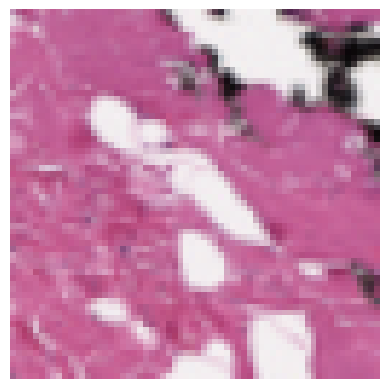

In [132]:
# Show a sample

torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
img = img.permute(1, 2, 0)  # Convert from (3, 64, 64) to (64, 64, 3)
plt.imshow(img.squeeze(), cmap = 'RdYlBu')
#plt.title(class_names[label])
plt.axis(False)
print(f"Image Size: {img.shape}")
print(f"Label: {label}, Label Size: {label.shape}")

### Creating a function to time our experiments

In [133]:
from timeit import default_timer as Timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):

  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [134]:
start_time = Timer()

end_time = Timer()
print_train_time(start=start_time, end=end_time, device = "cpu")

Train time on cpu: 0.000 seconds


4.522299786913209e-05

### Build a model

In [135]:
# Create a convolutional neural network

class BreastCancerImages(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
     super().__init__()
     self.conv_block_1 = nn.Sequential(
         nn.Conv2d(in_channels=input_shape,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1), # Hyperparmeters of our NN's
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                   out_channels = hidden_units,
                   kernel_size = 3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2)
     )
     self.conv_block_2 = nn.Sequential(
         nn.Conv2d(in_channels=hidden_units,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1), # Hyperparmeters of our NN's
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                   out_channels = hidden_units,
                   kernel_size = 3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2)
     )
     self.classifier = nn.Sequential(
         nn.Flatten(),
         nn.Linear(in_features=hidden_units*16*16,
                   out_features=output_shape)
     )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

### Instantiate the model

In [136]:
torch.manual_seed(42)

model = BreastCancerImages(input_shape=3, hidden_units=32, output_shape=2).to(device)

print(model)

BreastCancerImages(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=2, bias=True)
  )
)


### Setup a Helper function, loss function and optimizer

In [137]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [138]:
# Setup loss function/eval metrics/optimizer

from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [139]:
model.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.1471,  0.1597, -0.0451],
                        [ 0.1768, -0.0422,  0.0388],
                        [-0.0937,  0.1130,  0.1697]],
              
                       [[-0.1412,  0.1673,  0.0360],
                        [ 0.1422,  0.0261,  0.0928],
                        [-0.0272,  0.1484,  0.0284]],
              
                       [[-0.0898,  0.0491, -0.0887],
                        [-0.0226, -0.0782,  0.1277],
                        [-0.1519, -0.0887, -0.0543]]],
              
              
                      [[[-0.1157,  0.0182, -0.1901],
                        [ 0.1738, -0.1635,  0.1486],
                        [ 0.0320, -0.0625,  0.1189]],
              
                       [[ 0.0300,  0.1555,  0.0210],
                        [-0.0607,  0.0517, -0.0522],
                        [ 0.0810,  0.1718,  0.1112]],
              
                       [[-0.0841,  0.1111,  0.0344],
                 

### Training and testing model using our training and test functions

## Train Step Function

In [140]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

## Test Step Function

In [141]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Eval

In [144]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):


    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

          # Make our data device agnostic
          X, y = X.to(device), y.to(device)

          # Make predictions with the model
          y_pred = model(X)

          # Accumulate the loss and accuracy values per batch
          loss += loss_fn(y_pred, y)
          acc += accuracy_fn(y_true=y,
                            y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## Train and Test Loop

In [145]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Import tqdm for progress bar

from tqdm.auto import tqdm

# Measure tie

from timeit import default_timer as timer

train_time_start_model = timer()

# Train and test model

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                            end=train_time_end_model,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.68943 | Train accuracy: 53.55%
Test loss: 0.69024 | Test accuracy: 50.39%

Epoch: 1
-------
Train loss: 0.67336 | Train accuracy: 58.95%
Test loss: 0.63502 | Test accuracy: 66.77%

Epoch: 2
-------
Train loss: 0.67601 | Train accuracy: 58.18%
Test loss: 0.69556 | Test accuracy: 50.39%

Train time on cpu: 172.175 seconds


In [146]:
# Get model_2 results

model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_results

{'model_name': 'BreastCancerImages',
 'model_loss': 0.6955600380897522,
 'model_acc': 50.38961038961039}

### Model 2

In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BreastCancerImagesV2(nn.Module):

    def __init__(self, input_channels: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 8 *8, out_features=128),  # Adjust based on the output size after conv layers
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=output_shape),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x


### Instantiating Model 2

In [148]:
input_channels = 3  # RGB images
output_shape = 2  # Binary classification

model_2 = BreastCancerImagesV2(input_channels=input_channels, output_shape=output_shape).to(device)

print(model_2)

BreastCancerImagesV2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): Sigmoid()
  )
)


### Training and Testing Loop

In [149]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Import tqdm for progress bar

from tqdm.auto import tqdm

# Measure tie

from timeit import default_timer as timer

train_time_start_model = timer()

# Train and test model

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                            end=train_time_end_model,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.69303 | Train accuracy: 49.70%
Test loss: 0.69311 | Test accuracy: 49.61%

Epoch: 1
-------
Train loss: 0.69310 | Train accuracy: 49.74%
Test loss: 0.69310 | Test accuracy: 49.61%

Epoch: 2
-------
Train loss: 0.69309 | Train accuracy: 49.77%
Test loss: 0.69310 | Test accuracy: 49.61%

Train time on cpu: 127.852 seconds


In [150]:
# Get model_2 results

model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_2_results

{'model_name': 'BreastCancerImagesV2',
 'model_loss': 0.6930988430976868,
 'model_acc': 49.61038961038961}

### Compare model results and training time

In [151]:
from ast import Compare
import pandas as pd

Compare_results = pd.DataFrame([
    model_results,
    model_2_results
])

Compare_results

,model_name,model_loss,model_acc
0,BreastCancerImages,0.695560,50.38961
1,BreastCancerImagesV2,0.693099,49.61039
